# Analysis of PTEN/TPMT variants from CAGI5

In the following we analyse experimental data on PTEN and TPMT variants from [Matreyek KA et al, *Multiplex assessment of protein variant abundance by massively parallel sequencing*, Nat Genet (2018)](https://doi.org/10.1038/s41588-018-0122-z).

These data have been included as one of the challenges in the 5th edition of the Critical Assessment of Genome Interpretation (CAGI5) competition, as described in [Pejaver V et al, *Assessment of methods for predicting the effects of PTEN and TPMT protein variants*, Hum Mutat (2019)](https://doi.org/10.1002/humu.23838). We will therefore compare Rhapsody predictions with those from other participants in this challenge.

In [1]:
import sys, os, pickle, csv, glob
import prody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

## VAMP-seq experimental data from Matreyek et al.

In [3]:
folder = 'data/Matreyek_et_al_SI/'
exp_data = {
    'PTEN': pd.read_csv(folder + 'Supplementary_dataset_1-PTEN.txt', sep='\t', low_memory=False),
    'TPMT': pd.read_csv(folder + 'Supplementary_dataset_2-TPMT.txt', sep='\t', low_memory=False)}
exp_data['PTEN']

,variant,position,start,end,class,abundance_class,score,sd,expts,se,...,snap2_pred,fathmm_pred,ptenpred,lrt_pred,mut_taster_pred,metasvm_pred,metalr_pred,mcap_pred,cadd_pred,predictor_fraction_deleterious
0,M1V,1.0,M,V,missense,wt-like,1.065143,0.128434,4.0,0.064217,...,neutral,DAMAGING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667
1,T2A,2.0,T,A,missense,possibly_wt-like,0.775538,0.311177,5.0,0.139163,...,neutral,DAMAGING,NaN,D,D,T,D,D,B,0.384615
2,T2C,2.0,T,C,missense,NaN,NaN,NaN,NaN,NaN,...,neutral,DAMAGING,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
3,T2D,2.0,T,D,missense,wt-like,1.190667,0.089940,3.0,0.051927,...,neutral,DAMAGING,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,0.625000
4,T2E,2.0,T,E,missense,possibly_low,0.666592,0.529073,7.0,0.199971,...,neutral,DAMAGING,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8193,V403V,403.0,V,V,synonymous,possibly_wt-like,0.716056,0.427972,3.0,0.247090,...,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8194,V403W,403.0,V,W,missense,NaN,NaN,NaN,NaN,NaN,...,effect,DAMAGING,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,0.625000
8195,V403X,403.0,V,X,nonsense,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8196,V403Y,403.0,V,Y,missense,wt-like,1.179872,0.062335,4.0,0.031167,...,effect,DAMAGING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000


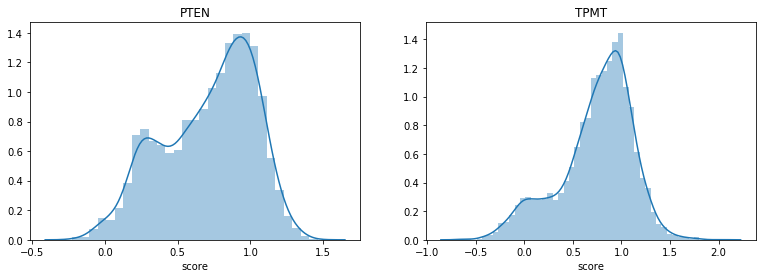

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
for i, prot in enumerate(['PTEN', 'TPMT']):
    sns.distplot(exp_data[prot]['score'].dropna(), ax=axes[i])
    axes[i].set_title(prot)

## Predictions from CAGI participants
Data from PTEN/TPMT CAGI challenge can be downloaded from the [CAGI website](https://genomeinterpretation.org/content/predict-effect-missense-mutations-pten-and-tpmt-protein-stability) (registered users only, see instructions in `data/CAGI/README`). For our analysis, we won't use the experimental data ("keys") from the CAGI website, but those published by the original authors of the study and imported above.

In [5]:
Uniprot_accs = {
    'PTEN': 'P60484',
    'TPMT': 'P51580'
}

In [6]:
import zipfile

CAGI_predictors_folder = 'local/TPMT and PTEN'
CAGI_keys_file = 'data/CAGI/CAGI5_TPMT_PTEN_answer_keys.csv'

if not os.path.isdir('local/TPMT and PTEN'):
    with zipfile.ZipFile('data/CAGI/TPMT_and_PTEN_latest.zip', 'r') as z:
        z.extractall('local')

In [7]:
CAGI_predictions = {}

for group in range(1,9):
    for submission in range(1,6):
        txt_file = os.path.join(
            CAGI_predictors_folder,
            f'Group_{group}/Group_{group}-prediction_file-{submission}.txt')
        if not os.path.isfile(txt_file):
            continue
        print('Importing', txt_file)
        # import data for each predictor and submission
        method = f'{group}.{submission}'
        content = pd.read_csv(txt_file, sep='\t')
        CAGI_predictions[method] = {}
        for i, row in content.iterrows():
            variant = row['Variant']
            if variant == 'WT':
                continue
            name = row['Gene_Symbol']
            acc = Uniprot_accs[name]
            pos = variant[1:-1]
            waa = variant[0]
            maa = variant[-1]
            SAV = f'{acc} {pos} {waa} {maa}'
            try:
                pred = np.float(row['Prediction'])
            except Exception:
                pred = np.nan
            CAGI_predictions[method][SAV] = pred

Importing local/TPMT and PTEN/Group_1/Group_1-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_1/Group_1-prediction_file-2.txt
Importing local/TPMT and PTEN/Group_1/Group_1-prediction_file-3.txt
Importing local/TPMT and PTEN/Group_2/Group_2-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_3/Group_3-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_4/Group_4-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_5/Group_5-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_5/Group_5-prediction_file-2.txt
Importing local/TPMT and PTEN/Group_6/Group_6-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_6/Group_6-prediction_file-2.txt
Importing local/TPMT and PTEN/Group_6/Group_6-prediction_file-3.txt
Importing local/TPMT and PTEN/Group_6/Group_6-prediction_file-4.txt
Importing local/TPMT and PTEN/Group_6/Group_6-prediction_file-5.txt
Importing local/TPMT and PTEN/Group_7/Group_7-prediction_file-1.txt
Importing local/TPMT and PTEN/Group_7/Group_7-pr

## Rhapsody: Predictions with unbiased classifier

A new classifier will be retrained by excluding PTEN/TPMT variants found in the training dataset.

In [8]:
# import the numpy structured array containing precomputed features 
# for the optimized training dataset
ID = np.load('../1-Training_Dataset/local/data/precomputed_features-ID_opt.npy')

In [9]:
sel_PTEN = [SAV.startswith(Uniprot_accs['PTEN']) for SAV in ID['SAV_coords']]
sel_TPMT = [SAV.startswith(Uniprot_accs['TPMT']) for SAV in ID['SAV_coords']]
print('{:<2} del. PTEN SAVs found in ID'.format(sum(ID[sel_PTEN]['true_label']==1)))
print('{:<2} neu. PTEN SAVs found in ID'.format(sum(ID[sel_PTEN]['true_label']==0)))
print('{:<2} del. TPMT SAVs found in ID'.format(sum(ID[sel_TPMT]['true_label']==1)))
print('{:<2} neu. TPMT SAVs found in ID'.format(sum(ID[sel_TPMT]['true_label']==0)))

56 del. PTEN SAVs found in ID
3  neu. PTEN SAVs found in ID
1  del. TPMT SAVs found in ID
4  neu. TPMT SAVs found in ID


Let's exclude these variants from the dataset. 

In [10]:
ID = ID[~np.logical_or(sel_PTEN, sel_TPMT)]
len(ID)

20297

We use this subset of the Integrated Dataset to train unbiased versions of the Rhapsody classifiers:

In [11]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [12]:
folder = 'local/results/'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
    logfile = os.path.join(folder, 'RF_training.log')
    prody.LOGGER.start(logfile)
    
    for clsf_version in ['full', 'reduced']:
        # training of the Random Forest classifier on the given set of features
        featset = rd.DEFAULT_FEATSETS[clsf_version]
        sel = ['SAV_coords', 'true_label'] + featset
        rd.trainRFclassifier(ID[sel])
        
        # store output files
        _folder = os.path.join(folder, clsf_version)
        os.mkdir(_folder)
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(_folder, file))
            
        prody.LOGGER.info('')
    prody.LOGGER.close(logfile)
else:
    print('Precomputed classifiers found.')

Precomputed classifiers found.


Let's now perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis) using the custom classifiers we just trained.

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2/`

In [13]:
full_clsf = 'local/results/full/trained_classifier.pkl'
reduced_clsf = 'local/results/reduced/trained_classifier.pkl'

In [14]:
rhapsody_preds = {}

for name, acc in Uniprot_accs.items():
    folder = f'local/results/predictions-{name}/'
    if not os.path.isdir(folder):
        # run rhapsody
        rh = rd.rhapsody(
            f'data/pph2/pph2-full-{name}.txt', query_type='PolyPhen2',
            main_classifier=full_clsf, aux_classifier=reduced_clsf)
        # store output files
        os.mkdir(folder)
        for f in glob.glob('rhapsody-*.*'):
            os.rename(f, os.path.join(folder, f))
    else:
        with open(os.path.join(folder, 'rhapsody-pickle.pkl'), 'rb') as f:
            rh = pickle.load(f)
        print(f'Precomputed predictions for {name} imported.')
    # store results in dictionary
    rhapsody_preds[name] = rh

Precomputed predictions for PTEN imported.
Precomputed predictions for TPMT imported.


## Comparison between experimental data and computational predictions
We will only consider experimental measurements on *missense* variants and compare them with computational predictions from:
* Rhapsody
* PolyPhen-2
* EVmutation
* predictors from CAGI competition

In [15]:
# Alignment of computational predictions to exp. data

missense_data = {}
aligned_Rhapsody_output = {}
aligned_CAGI_preds = {}

for name, acc in Uniprot_accs.items():
    rh = rhapsody_preds[name]
    data = exp_data[name]
    # select only exp. data for missense variants
    data = data[data['class'] == 'missense']
    # select only valid exp. scores
    missense_data[name] = data[~np.isnan(data['score'])]
    SAV_list = []
    for i, row in missense_data[name].iterrows():
        pos = int(row['position'])
        waa = row['start']
        maa = row['end']
        SAV = f'{acc} {pos} {waa} {maa}'
        SAV_list.append(SAV)
    # align Rhapsody output
    idx_map = {s: i for i, s in enumerate(rh.getSAVcoords())}
    sel = [idx_map[SAV] for SAV in SAV_list]
    aligned_Rhapsody_output[name] = rh.getPredictions()[sel]
    # align CAGI predictions
    aligned_CAGI_preds[name] = {}
    for method, preds in CAGI_predictions.items():
        sc = np.array([preds.get(SAV, np.nan) for SAV in SAV_list])
        # we'll define classes based on an arbitrary threshold of 0.5
        cl = np.where(sc < .5, 1, 0)
        cl[np.isnan(sc)] = -1
        # save as structured array
        dt = np.dtype([('score', 'f'), ('path. class', 'i')])
        a = np.empty(len(SAV_list), dtype=dt)
        a['score'] = sc
        a['path. class'] = cl
        aligned_CAGI_preds[name][method] = a

/home/luca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [16]:
# Accuracy metrics calculation

from scipy.stats import spearmanr

exp_class_mapping = {
    'low': 1, 'possibly_low': 1, 
    'possibly_wt-like': 0, 'wt-like': 0}
comp_class_mapping = {
    'deleterious': 1, 'prob.delet.': 1,
    'neutral': 0, 'prob.neutral': 0,
    '?': -1}

metrics = {}
for i, prot in enumerate(['PTEN', 'TPMT']):
    metrics[prot] = {}
    # retrieve experimental scores and classes
    exp_score = missense_data[prot]['score']
    exp_class = np.array([
        exp_class_mapping[c] for c in missense_data[prot]['abundance_class']])
    for method in ['Rhapsody', 'PolyPhen-2', 'EVmutation']:
        # retrieve computational predictions
        if method == 'Rhapsody':
            fs, fc, sign = 'score', 'path. class', +1
        elif method == 'PolyPhen-2':
            fs, fc, sign = 'PolyPhen-2 score', 'PolyPhen-2 path. class', +1
        else:
            fs, fc, sign = 'EVmutation score', 'EVmutation path. class', -1
        comp_score = aligned_Rhapsody_output[prot][fs]
        comp_class = np.array([
            comp_class_mapping[c] for c in aligned_Rhapsody_output[prot][fc]])
        # compute accuracy metrics and other info
        sel = ~np.isnan(comp_score)
        sm = rd.calcScoreMetrics(exp_class[sel], sign * comp_score[sel])
        for k in ['ROC', 'optimal cutoff', 'PRC']:
            sm.pop(k)
        cm = rd.calcClassMetrics(exp_class[sel], comp_class[sel])
        rho = abs(spearmanr(exp_score, comp_score, nan_policy='omit')[0])
        metrics[prot][method] = {
            **sm, **cm, 'Spearman': rho, 'n. SAVs': sum(sel)}
    for method, preds in aligned_CAGI_preds[prot].items():
        comp_score = preds['score']
        comp_class = preds['path. class']
        # compute accuracy metrics and other info
        sel = ~np.isnan(comp_score)
        sm = rd.calcScoreMetrics(exp_class[sel], comp_score[sel])
        cm = rd.calcClassMetrics(exp_class[sel], comp_class[sel])
        rho = abs(spearmanr(exp_score, comp_score, nan_policy='omit')[0])
        metrics[prot][method] = {
            **sm, **cm, 'Spearman': rho, 'n. SAVs': sum(sel)}

## Figures

In [17]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

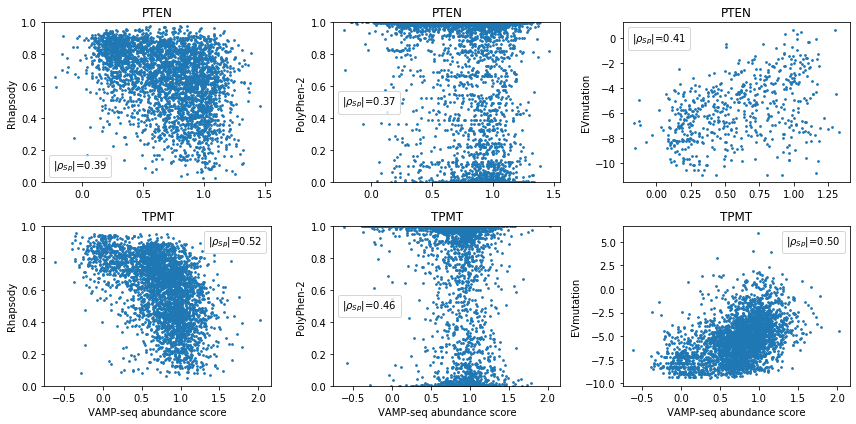

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12,6))

for i, prot in enumerate(['PTEN', 'TPMT']):
    for j, method in enumerate(['Rhapsody', 'PolyPhen-2', 'EVmutation']):
        exp_score = missense_data[prot]['score']
        field = 'score' if method == 'Rhapsody' else method + ' score'
        comp_score = aligned_Rhapsody_output[prot][field]
        rho = metrics[prot][method]['Spearman']
        text = r'|$\rho_{Sp}$|' + f'={rho:.2f}'
        if method in ['Rhapsody', 'PolyPhen-2']:
            axes[i, j].set_ylim((0, 1))
        axes[i, j].set_title(prot)
        axes[i, j].set_ylabel(method)
        axes[i, j].scatter(exp_score, comp_score, s=3, label=text)
        leg = axes[i, j].legend(handlelength=0, handletextpad=0)
        for item in leg.legendHandles:
            item.set_visible(False)
        
axes[1, 0].set_xlabel('VAMP-seq abundance score')
axes[1, 1].set_xlabel('VAMP-seq abundance score')
axes[1, 2].set_xlabel('VAMP-seq abundance score')

fig.tight_layout()
fig.savefig('local/figures/PTEN_TPMT_Spearman.png', dpi=300);

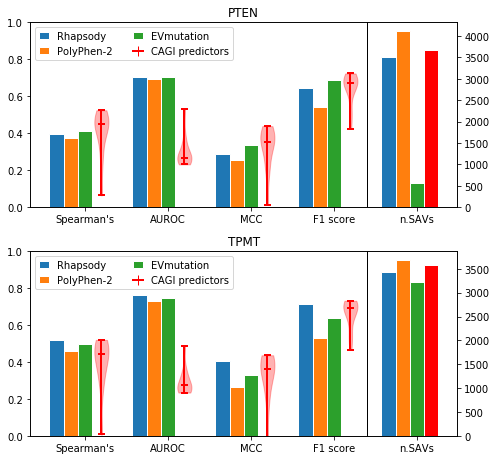

In [19]:
import matplotlib.lines as ml

sel_metrics = ['Spearman', 'AUROC', 'MCC', 'F1 score']

fig, axes = plt.subplots(2, 1, figsize=(7,6.5))

dn = 2
dx = .17
opts = {'width': dx, 'edgecolor': 'w'}
for i, prot in enumerate(['PTEN', 'TPMT']):
    ax = axes[i]
    ax2 = ax.twinx()
    ax.set_title(prot)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["Spearman's", 'AUROC', 
                        'MCC', 'F1 score', 'n.SAVs'])
    ax.set_ylim((0, 1))
    
    # bar plots
    for j, method in enumerate(['Rhapsody', 'PolyPhen-2', 'EVmutation']):
        x = np.arange(4)
        y = [metrics[prot][method][sm] for sm in sel_metrics]
        y2 = metrics[prot][method]['n. SAVs']
        color = f'C{min(j,3)}'
        ax.bar(x+(j-dn)*dx, y, color=color, **opts, label=method)
        ax2.bar(4+(j-dn)*dx, y2, color=color, **opts)
    ax2.bar(4+(3-dn)*dx, metrics[prot]['1.1']['n. SAVs'], color='red', **opts)
    
    # separator
    plt.axvline(x=3.4, color='k', linestyle='-', lw=1)
    
    # violin plots
    distributions = []
    for sm in sel_metrics:
        distributions.append([
            metrics[prot][method][sm] for method in 
            aligned_CAGI_preds['PTEN'].keys()])
    v = ax.violinplot(distributions, np.arange(len(distributions))+.2,
                      widths=dx, showmedians=True)
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = v[partname]
        vp.set_edgecolor('red')
        vp.set_linewidth(2)
    for b in v['bodies']:
        b.set_color('red')
        
    line1 = ml.Line2D(range(1), range(1), color="red", lw=2,
                      marker='+', markersize=10, markerfacecolor="red")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(line1)
    labels.append('CAGI predictors')
    ax.legend(handles, labels, loc='upper left', ncol=2, handlelength=1)
        
fig.tight_layout()
fig.savefig('local/figures/PTEN_TPMT_metrics.png', dpi=300);